In [0]:
class Activation(object):

      
    def __relu(self,x):
        
        return np.maximum(0,x)
      
    def __relu_deriv(self,a):
        a[a>=0]=1
        a[a<0]=0
        return a
      
    def __softmax(self, x):
        """
        x is of shape(m,n_in)
        """
        y= np.exp(x)/np.sum(np.exp(x),axis=1).reshape(-1,1)
        assert(y.shape == x.shape)
        
        return y
      
    def __softmax_deriv(self, a):
        
        y = a*(1-a)
        assert(y.shape == a.shape)
        return y

    def __init__(self,activation='relu'):
        if activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv

In [111]:
#@title

np.exp(q)/np.sum(np.exp(q),axis=1).reshape(-1,1)

array([[0.01606255, 0.32262497, 0.32262497, 0.01606255, 0.32262497],
       [0.10501196, 0.03863174, 0.2854521 , 0.2854521 , 0.2854521 ],
       [0.01499127, 0.11077134, 0.0407505 , 0.81849562, 0.01499127]])

In [0]:
class HiddenLayer(object):    
    def __init__(self, n_in, n_out, keep_prob, beta = 0, W=None, b=None, activation = "relu" ):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        
        self.act = activation
        self.keep_prob  = keep_prob
        self.beta = beta
        self.input=None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        np.random.seed(1)
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out))*0.01,
                high=np.sqrt(6. / (n_in + n_out))*0.01,
                size=(n_in, n_out)
        )
        


        self.b = np.zeros((1, n_out))
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.v_dW = np.zeros(self.W.shape)
        self.v_db = np.zeros(self.b.shape)
        
        #print("v_db.shape: ", self.v_db.shape)
        
    def forward(self, input):
        '''
        :type input: numpy.array
        :input.shape = (m, n_in), b.shape = (1, n_out), W.shape = (n_in, n_out)
        :lin_output.shape = (m, n_out)
        '''

        lin_output = np.dot(input, self.W) + self.b
        
        assert(self.W.shape[1] == self.b.shape[1])
        assert(input.shape[1] == self.W.shape[0])
        assert(input.shape[0] == lin_output.shape[0])
  
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )

        keep_prob = self.keep_prob
        output = np.atleast_2d(self.output)

        d = np.random.rand(output.shape[0],output.shape[1]) < keep_prob
        output = np.multiply(d, output)
        output /= keep_prob
        
        assert(output.shape == self.output.shape)

        self.input=input
        self.output = output
        return self.output
    
    def backward(self, delta):       
        """
        :self.input.shape = (m, n_in)
        :delta.shape = (m, n_out)
        :self.grad_W.shape = (n_in, n_out)
        :self.grad_b.shape = (1, n_out)
        :delta_.shape = (m, n_in)
        """
        delta = np.atleast_2d(delta)
        self.input = np.atleast_2d(self.input)
        assert(self.input.shape[0] == delta.shape[0])
        m = self.input.shape[0]
        
        self.grad_W = self.input.T.dot(delta)/m
        self.grad_b = np.sum(delta, axis = 0)/m
        
        self.grad_b = np.atleast_2d(self.grad_b)
        
        
        beta = self.beta

        self.v_dW = beta * self.v_dW + (1-beta) * self.grad_W
        self.v_db = beta * self.v_db + (1-beta) * self.grad_b

        assert(self.v_dW.shape == self.grad_W.shape)
        assert(self.v_db.shape == self.grad_b.shape)
        
        keep_prob = self.keep_prob
        
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        delta_ /= keep_prob
        assert(delta_.shape == self.input.shape)
        return delta_

In [13]:
#@title
import numpy as np
import math
np.random.seed(1)
m=5
X = np.random.rand(5,2)
labels = np.random.randint(5, size = (5,1))
y=  (np.arange(5) == labels).astype(float)
permutation = list(np.random.permutation(m))
shuffled_X = X[permutation, :]
shuffled_y = y[permutation, :]

minibatch_size = 2
num_com_batches = math.floor(m/minibatch_size)
minibatches = []      
for k in range(0, num_com_batches):
    mini_batch_X = shuffled_X[k*minibatch_size:(k+1)* minibatch_size, : ]
    mini_batch_y = shuffled_y[k*minibatch_size:(k+1)* minibatch_size, : ]
    mini_batch = (mini_batch_X, mini_batch_y)
    minibatches.append(mini_batch)

if m % minibatch_size !=0: 
    mini_batch_X = shuffled_X[(k+1)*minibatch_size:, : ]
    mini_batch_y = shuffled_y[(k+1)*minibatch_size:, : ]
    mini_batch = (mini_batch_X, mini_batch_y)
    minibatches.append(mini_batch)
for i in minibatches:
  
  print(i)

(array([[0.18626021, 0.34556073],
       [0.417022  , 0.72032449]]), array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]]))
(array([[1.46755891e-01, 9.23385948e-02],
       [1.14374817e-04, 3.02332573e-01]]), array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]]))
(array([[0.39676747, 0.53881673]]), array([[0., 0., 1., 0., 0.]]))


In [6]:
class MLP:
    """
    """      
    def __init__(self, layers, keep_prob, beta=0, mini_batch_size = 1):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values

        """        
        ### initialize layers
        self.labels = None

        self.X =None
        self.mini_batch_size = mini_batch_size
        self.y = None
        self.layers=[]
        self.layers_number = layers
        self.params=[]
        self.beta = beta
        self.keep_prob = keep_prob
        
        
        self.num_features = None
        self.yn=None
        self.m=None
        self.activation= None 
        
        for i in range(len(layers)-2):
            self.layers.append(HiddenLayer(layers[i],layers[i+1], activation="relu", beta = self.beta, keep_prob = self.keep_prob))

        L = len(layers)
        self.layers.append(HiddenLayer(layers[L-2],layers[L-1], activation="softmax", beta = self.beta, keep_prob =1))
            
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        
        return output
    
    def criterion_cross_entropy(self, y, y_hat):
        """
        y.shape = y-hat.shape = (m, yn)
        delta.shape = (m, yn)
        """
      
        assert(y.shape == y_hat.shape)
        
        activation_deriv=Activation("softmax").f_deriv
        
        loss = -np.sum(np.log(y_hat) * y) 
                
        error = y-y_hat
        
        delta = error*activation_deriv(y_hat)  
        assert(delta.shape == y.shape)
        return loss, delta
      
    
    def backward(self,delta):        
        for layer in reversed(self.layers):
            delta=layer.backward(delta)
            
    def update(self,lr):
        """
        v_db.shape = (m, n_out)
        b.shape = (1, n_out)
        """
        for layer in self.layers:
            layer.W += lr * layer.v_dW                   
            layer.b += lr * layer.v_db
            
   
    def create_mini_batch(self):
        """
        
        """
        #initializations
        np.random.seed(1)
        m = self.m
        mini_batch_size = self.mini_batch_size
        labels = self.labels
        mini_batches = []        
        y = self.y        
        X = self.X
        yn = self.yn
        num_features = self.num_features
        
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_y = y[permutation, :]
        
        labels = labels[permutation]
        mini_batches_labels = labels

        num_com_batches = math.floor(m/mini_batch_size)
        
        for k in range(0, num_com_batches):
            mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch_y = shuffled_y[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            assert(mini_batch_X.shape == (mini_batch_size, num_features))
            assert(mini_batch_y.shape == (mini_batch_size, yn))
            
        if m % mini_batch_size !=0: 
            mini_batch_X = shuffled_X[(k+1)*mini_batch_size:, : ]
            mini_batch_y = shuffled_y[(k+1)*mini_batch_size:, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            
        return mini_batches, mini_batches_labels
      
    
    
    def fit(self, X, labels, learning_rate=0.1, epochs=100):
        
        """
        :X.shape = (m, num_features)
        :labels.shape = (m, 1) / (m,)
        :y.shape = (m, yn)
        :y_hat.shape = y.shape
        """
        self.X = X
        labels = labels.flatten()
        self.labels = labels
        assert(X.shape[0] == labels.shape[0])
        
        
        y = (np.arange(self.layers_number[-1]) == labels[:, None]).astype(float)
        self.y = y
        self.yn = y.shape[1]
        assert(y.shape[0] == X.shape[0])
                
        num_features = X.shape[1]
        self.num_features = num_features
       
        m = X.shape[0]
        self.m = m
        
        to_return_cost = np.zeros(epochs)
        to_return_accuracy = np.zeros(epochs)
        
       
        mini_batches, mini_batches_labels = self.create_mini_batch()

        for k in range(epochs):
            p_labels = []

            for mini_batch in mini_batches:
                
                mini_batch_X, mini_batch_y = mini_batch
                
                mini_batch_y_hat = self.forward(mini_batch_X)
                
                loss, delta=self.criterion_cross_entropy(mini_batch_y, mini_batch_y_hat)
                
                self.backward(delta)
                
                self.update(learning_rate)
                
                p = mini_batch_y_hat.argmax(axis = 1)
                
                p_labels = np.append(p_labels, p)
    
            to_return_cost[k] = np.mean(loss)
            
            assert(len(p_labels) == len(mini_batches_labels))
            to_return_accuracy[k] = str(np.sum((p_labels == mini_batches_labels)/m)) 
            
            if k % 100 ==0:
              print("Cost after iteration %i: %f" %(k, to_return_cost[k]))
              print("Accuracy after iteration %i: %f" %(k, to_return_accuracy[k]))

        print("accuracy: ", to_return_accuracy[k])
        print("cost: ", to_return_cost[k])
        
        return to_return_cost, to_return_accuracy
      
      

""" def predict(self, X_test, y_test):

    X_test = np.array(X_test)
    yn=self.yn
    m=self.m
    output = np.zeros([m,yn])

    self.forward().keep_prob = 1
    for i in np.arange(m):
        output[i] = self.forward(x[i,:])

        return output"""

' def predict(self, X_test, y_test):\n\n    X_test = np.array(X_test)\n    yn=self.yn\n    m=self.m\n    output = np.zeros([m,yn])\n\n    self.forward().keep_prob = 1\n    for i in np.arange(m):\n        output[i] = self.forward(x[i,:])\n\n        return output'

In [0]:
class MLP_train():
    """
    hidden layers - a python list
    """
    def __init__(self, m, num_features = 128, yn = 10):
        
        
          
        self.m = m
        self.num_features = num_features
        self.yn = yn

        self.X_train = X[0:m,:]
        self.labels_train = labels[0:m]
   
    def fit(self, mini_batch_size = 1, beta = .8, keep_prob = 1, learning_rate = .005, epochs = 100, hidden_layers = None):
        
        m = self.m
        num_features = self.num_features
        yn = self.yn
        
        if mini_batch_size > m: 
          raise ValueError('mini_batch_size too big')
         
        if hidden_layers == None:
            layers_number = [num_features, yn]
        else:
            layers_number = [num_features] + hidden_layers + [yn]
          
        case = MLP(layers_number, keep_prob, beta, mini_batch_size)
        cost, accuracy = case.fit(self.X_train, self.labels_train, learning_rate, epochs)

        %matplotlib inline
        
        pl.plot(cost)
        pl.plot(accuracy)
        

    

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_128.h5 to train_128.h5
Saving train_label.h5 to train_label.h5
User uploaded file "train_128.h5" with length 61442144 bytes
User uploaded file "train_label.h5" with length 482144 bytes


In [0]:
import numpy as np
with h5py.File('train_128.h5','r') as H:
    X = np.copy(H['data'])

with h5py.File('train_label.h5','r') as H:
    labels = np.copy(H['label'])

Cost after iteration 0: 73.682723
Accuracy after iteration 0: 0.187500
Cost after iteration 100: 73.682370
Accuracy after iteration 100: 0.187500
Cost after iteration 200: 73.681982
Accuracy after iteration 200: 0.187500
Cost after iteration 300: 73.681594
Accuracy after iteration 300: 0.187500
Cost after iteration 400: 73.681206
Accuracy after iteration 400: 0.187500
Cost after iteration 500: 73.680818
Accuracy after iteration 500: 0.187500
Cost after iteration 600: 73.680430
Accuracy after iteration 600: 0.187500
Cost after iteration 700: 73.680042
Accuracy after iteration 700: 0.187500
Cost after iteration 800: 73.679654
Accuracy after iteration 800: 0.187500
Cost after iteration 900: 73.679266
Accuracy after iteration 900: 0.187500
Cost after iteration 1000: 73.678878
Accuracy after iteration 1000: 0.187500
Cost after iteration 1100: 73.678490
Accuracy after iteration 1100: 0.187500
Cost after iteration 1200: 73.678103
Accuracy after iteration 1200: 0.187500
Cost after iteration 13

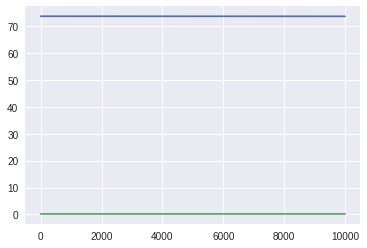

In [35]:
import matplotlib.pyplot as pl
import math
test_1 = MLP_train(m=32)
test_1.fit(epochs = 10000, mini_batch_size = 32, hidden_layers = [5,2,5], keep_prob = 0.5, learning_rate = .00005, beta = 0.9)

In [0]:
#@title
test_2 = MLP_train(m=20000)
test_2.fit(epochs = 10000, mini_batch_size = 128, hidden_layers = [], keep_prob =.5, learning_rate = .0000075, beta = .8)

In [115]:
#@title
class MLP_train_random():
    """
    hidden layers - a python list
    """
    def __init__(self, m, num_features, yn):
        
        
          
        self.m = m
        self.num_features = num_features
        self.yn = yn
        np.random.seed(1)
        self.X_train = np.random.rand(m, num_features)
        self.labels_train = np.random.randint(yn, size = (m))
    def fit(self, mini_batch_size = 1, beta = .8, keep_prob = 1, learning_rate = .005, epochs = 100, hidden_layers = None):
        
        m = self.m
        num_features = self.num_features
        yn = self.yn
        
        if mini_batch_size > m: 
          raise ValueError('mini_batch_size too big')
         
        if hidden_layers == None:
            layers_number = [num_features, yn]
        else:
            layers_number = [num_features] + hidden_layers + [yn]
          
        case = MLP(layers_number, keep_prob, beta, mini_batch_size)
        cost, accuracy = case.fit(self.X_train, self.labels_train, learning_rate, epochs)

        %matplotlib inline
        
        pl.plot(cost)
        pl.plot(accuracy)
  

Cost after iteration 0: 16.094379
Accuracy after iteration 0: 0.000000
Cost after iteration 100: 15.479602
Accuracy after iteration 100: 1.000000
accuracy:  1.0
cost:  14.84518929283325


ValueError: ignored